# Keyword Extraction

This notebook shows various keyword extraction to extract the key themes in the reviews as a first step to infer topics which can be used as apsects for each category. Various methods are considered, including extracting noun phrases and keywords for each category.

* Section 1 - preprocessing
* Section 2 - noun phrase extraction
* Section 3 - TextRank
* Section 4 - Keyword extraction - unigrams
* Section 5 - Bigrams
* Section 6 - Noun-adjective pairs
* Section 7 - Summary


# Import Libraries and Dataset

In [490]:
#!pip install pyLDAvis
!pip install contractions

In [698]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contractions
import string
#from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import nltk
nltk.download('brown')
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer, word_tokenize,sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import TfidfModel
from gensim.summarization import keywords
from operator import itemgetter
from collections import Counter
import ast
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\imoge\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [492]:
# Bring in dataframe of cleaned sentences from Text Processing Notebook
df_train = pd.read_csv("train_cleaned.csv",index_col = 0)
df_val = pd.read_csv("val_cleaned.csv",index_col = 0)
df_test = pd.read_csv("test_cleaned.csv",index_col = 0)

In [493]:
# Get shape
df_train.shape

(1453, 7)

In [494]:
# Look at first few rows
df_train.head()

,OrgInd,Town,Category,Score,Sent,Sent_clean,Pos
0,245,Bognor,Accommodation,0,"Central B & B We had room 6, excellent view, w...",central room excellent view could see sea room...,"[('central', 'JJ'), ('room', 'NN'), ('excellen..."
1,209,Littlehampton,Accommodation,1,Not what it used to be... We lived in the area...,not used lived area year fact daughter worked ...,"[('not', 'RB'), ('used', 'VBN'), ('lived', 'VB..."
2,28,Bognor,Accommodation,0,Easter Break 5 days at Bognor Stayed in Rockpo...,easter break day stayed rockpool xu apartment ...,"[('easter', 'JJ'), ('break', 'NN'), ('day', 'N..."
3,365,Arundel,Accommodation,0,Fantastic pub inn tucked away at top of Arunde...,fantastic pub tucked away top asunder high str...,"[('fantastic', 'JJ'), ('pub', 'NN'), ('tucked'..."
4,389,Arundel,Accommodation,1,Charging top prices for low quality food Had t...,charging top price low quality food buttermilk...,"[('charging', 'VBG'), ('top', 'JJ'), ('price',..."


In [495]:
# Look at the split over towns
df_train["Town"].value_counts()

Bognor           557
Arundel          460
Littlehampton    436
Name: Town, dtype: int64

In [496]:
# Look at the split over categories
df_train["Category"].value_counts()

Food             1062
Accommodation     332
Attractions        59
Name: Category, dtype: int64

In [497]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1453 entries, 0 to 1452
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   OrgInd      1453 non-null   int64 
 1   Town        1453 non-null   object
 2   Category    1453 non-null   object
 3   Score       1453 non-null   int64 
 4   Sent        1453 non-null   object
 5   Sent_clean  1453 non-null   object
 6   Pos         1453 non-null   object
dtypes: int64(2), object(5)
memory usage: 90.8+ KB


# Section 2: Noun Phrase Extraction - unweighted and weighted

A noun phrase is a small group of words which contains a noun


## Unweighted

In [498]:
# Create function to extract noun phrases from a review using TextBlob
def noun_finder(x):
    blob = TextBlob(x)
    return blob.noun_phrases

In [566]:
# Sample review
example = h_train["Sent_clean"].iloc[0]
example2 = h_train["Sent_clean"].iloc[1]
example

'central room excellent view could see sea room top floor one single told occupancy given workman digging part put new swimming pool accomodation parking could problem alison gave u permit sort u thankfully good breakfast hash brown come english breakfast edible bubble squeak black pudding room clean shade green decor bit ofputting lime green armchair not thing not cheap near high street decide'

In [635]:
example_noun_phrases = noun_finder(example)
example_noun_phrases

WordList(['central room', 'excellent view', 'sea room top floor', 'pool accomodation', 'problem alison', 'sort u', 'good breakfast hash', 'english breakfast edible bubble squeak', 'clean shade green decor bit', 'lime green armchair', 'high street'])

In [660]:
# Put to a normal python list 
new_list = []
for item in example_noun_phrases:
    new_list.append(item)

In [665]:
new_list = [new_list]

In [499]:
# Make sure sentences are strings and then apply the function to whole dataframe
df_train["Sent_clean"] = df_train["Sent_clean"].astype(str)
df_train["noun_phrases"] = df_train["Sent_clean"].apply(lambda x: noun_finder(x))

In [500]:
# Remove empty lists
df_train = df_train[(df_train['noun_phrases'].str.len() != 0)]

In [501]:
# Revised shape
df_train.shape

(1452, 8)

In [502]:
# Split between the categories - accommodation, food and attractions
h_train = df_train[df_train["Category"] == "Accommodation"]
f_train = df_train[df_train["Category"] == "Food"]
a_train = df_train[df_train["Category"] == "Attractions"]

Extracting noun phrases for each review does appear to identify helpful information at a detail level.

In [555]:
# Function to extract the noun phrases into list of lists
def noun_extract(df):
    words = df["noun_phrases"].apply(lambda x: [item for item in x]).tolist()
    return words

In [504]:
# Apply to dataframes
words_accom = noun_extract(h_train)
words_food = noun_extract(f_train)
words_attract = noun_extract(a_train)

In [505]:
words_accom[0:1]

[['central room',
  'excellent view',
  'sea room top floor',
  'pool accomodation',
  'problem alison',
  'sort u',
  'good breakfast hash',
  'english breakfast edible bubble squeak',
  'clean shade green decor bit',
  'lime green armchair',
  'high street']]

## Weighted

In [626]:
# Example review text
example

'central room excellent view could see sea room top floor one single told occupancy given workman digging part put new swimming pool accomodation parking could problem alison gave u permit sort u thankfully good breakfast hash brown come english breakfast edible bubble squeak black pudding room clean shade green decor bit ofputting lime green armchair not thing not cheap near high street decide'

In [671]:
# Set dictionary and corpus and print out the words and number of occurrences for each word
dictionary  = corpora.Dictionary(new_list)
corpus = [dictionary.doc2bow(word) for word in new_list]
for doc in corpus:
    print([[mydict[id], freq] for id, freq in doc])

[['central room', 1], ['clean shade green decor bit', 1], ['english breakfast edible bubble squeak', 1], ['excellent view', 1], ['good breakfast hash', 1], ['high street', 1], ['lime green armchair', 1], ['pool accomodation', 1], ['problem alison', 1], ['sea room top floor', 1], ['sort u', 1]]


In [672]:
# Use the TFIDF weighting and print out words and weights from the example
tfidf = models.TfidfModel(corpus, smartirs='ntc')
for doc in tfidf[corpus]:
    print([[mydict[id], np.around(freq, decimals=2)] for id, freq in doc])

[['central room', 0.3], ['clean shade green decor bit', 0.3], ['english breakfast edible bubble squeak', 0.3], ['excellent view', 0.3], ['good breakfast hash', 0.3], ['high street', 0.3], ['lime green armchair', 0.3], ['pool accomodation', 0.3], ['problem alison', 0.3], ['sea room top floor', 0.3], ['sort u', 0.3]]


In [583]:
# Create the gensim dictionary and corpus and get the weighted noun phrases bassed on the TFIDF model (for whole dataframe)
# Code source: Text Analytics with Python (Sarkar)

def createdictionary(df):
    dictionary  = corpora.Dictionary(df)
    corpus = [dictionary.doc2bow(word) for word in df]
    model = TfidfModel(corpus) 
    vector = model[corpus]
    weighted_noun_phrases = {dictionary.get(idx): value for doc in vector for idx, value in doc}
    weighted_noun_phrases_s = sorted(weighted_noun_phrases.items(),key = itemgetter(1),reverse = True)
    weighted_noun_phrases_s = [(term,round(wt,3)) for term,wt in weighted_noun_phrases_s]
    
    return weighted_noun_phrases, weighted_noun_phrases_s

In [584]:
# Run function against the noun phrases word list
weighted_noun_accom = createdictionary(words_accom)[1]
weighted_noun_food = createdictionary(words_food)[1]
weighted_noun_attract = createdictionary(words_attract)[1]

In [508]:
# Get the top 10 weighted noun phrases for accomodation
weighted_noun_accom[:10]

[('friendly place stay', 0.894),
 ('littlehampton oh', 0.75),
 ('clean warm.breakfast plentiful tasty', 0.707),
 ('good text email staff criticism decor room', 0.707),
 ('busy mum', 0.707),
 ('friendly kind place', 0.707),
 ('main entrance axe entrance', 0.707),
 ('main entrance disability', 0.707),
 ('basic travelodges inn', 0.707),
 ('need overall', 0.707)]

In [509]:
# Get the top 10 weighted noun phrases for food
weighted_noun_food[:10]

[('great food jasmine tammy', 1.0),
 ('gem accident coffee staff', 1.0),
 ('good ufc', 1.0),
 ('excellent meal food', 1.0),
 ('bad customer relation', 1.0),
 ('area april hen night', 1.0),
 ('usual pub grub service', 1.0),
 ('bill 29. party 8.', 1.0),
 ('meal delicious sunday roast staff awesome food', 1.0),
 ('expectation delicious food exceptional wine', 1.0)]

In [510]:
# Get the top 10 weighted noun phrases for attractions
weighted_noun_attract[:10]

[('bin lol', 1.0),
 ('soft play', 0.802),
 ('lovely food', 0.729),
 ('ground self spoilt family u', 0.707),
 ('holiday family dog', 0.707),
 ('local shop', 0.707),
 ('way high adult party', 0.707),
 ('beach dog', 0.577),
 ('big pebble walk', 0.577),
 ('nice dog tide', 0.577)]

This does highlight noun phrases but is perhaps too specific, a more general summary is more helpful when considering a large number of reviews.

# Section 3: Keywords in Gensim using TextRank

Useful to find most relevant sentences or keywords in text. Graph based model so two words found together given higher weight

Source: https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf

In [677]:
# Function to join list of lists to list of strings then join to get a string. Textrank is a graph-based ranking model
    
def join_words(df):
    words_joined = [','.join(word) for word in df] 
    words_joined = ''.join(words_joined)
    key_words = keywords(words_joined,ratio = 1.0, scores = True, lemmatize = True)
    [(item,round(score,3)) for item,score in key_words[:15]]
    return key_words

In [679]:
# Example review
print(join_words(new_list))

[('breakfast', 0.3271584398929237), ('room', 0.2715342606344531), ('alison', 0.2209085350518678), ('accomodation', 0.21144897561639747), ('squeak shade green decor', 0.2087990178594937), ('view', 0.1825972809866289), ('edible bubble', 0.17402620012362077), ('bit', 0.17067215521670961), ('hash', 0.16907513401674962), ('floor', 0.12158316097942867), ('street', 0.11295160675812556), ('central', 0.10463174076214639)]


In [673]:
# Run function against the noun phrases dataframe
key_words_accom = join_words(words_accom)
key_words_food = join_words(words_food)
key_words_attract = join_words(words_attract)

In [676]:
# First 10 key words - weighted
key_words_accom[0:10]

[('room', 0.4013187462734255),
 ('staff', 0.21018994448200798),
 ('food', 0.1381372717729494),
 ('breakfast', 0.13364229007144154),
 ('hotels expedite', 0.1268328573914479),
 ('lovely', 0.11035801064670926),
 ('area', 0.10522561445357863),
 ('bed', 0.10266964835127043),
 ('service', 0.09891203331906172),
 ('floor', 0.09715593454595772)]

In [514]:
key_words_food[0:10]

[('food', 0.4082934920343299),
 ('serviceate', 0.22634296648545033),
 ('staff', 0.20814669805768246),
 ('table', 0.1610509328649532),
 ('place', 0.14078649495581932),
 ('menu', 0.13130242318556162),
 ('birthday restaurant', 0.10918795495013355),
 ('chip fish', 0.10706428766839243),
 ('drink', 0.08553543629449094),
 ('waitress', 0.08319197608953838)]

In [515]:
key_words_attract[0:10]

[('goodness', 0.2667026828364715),
 ('great', 0.19421556639883336),
 ('cafe visit', 0.15796843890985524),
 ('park', 0.12585717332105012),
 ('lovely', 0.11312002288952913),
 ('beautiful', 0.10692160302106894),
 ('old', 0.09725674893268463),
 ('toilet', 0.09686780941270524),
 ('beach resident', 0.09287771617391655),
 ('family kid', 0.08677690339199262)]

* Service, food and staff are the main themes for food outlets, for accommodation and attractions it is less clearcut
* Many of the words are very specific rather than being general aspects

# Section 4: Extracting Nouns - Unigrams

In [516]:
# check one line of the Pos column
print(h_train.Pos.iloc[0])

[('central', 'JJ'), ('room', 'NN'), ('excellent', 'JJ'), ('view', 'NN'), ('could', 'MD'), ('see', 'VB'), ('sea', 'JJ'), ('room', 'NN'), ('top', 'JJ'), ('floor', 'NN'), ('one', 'CD'), ('single', 'JJ'), ('told', 'VBD'), ('occupancy', 'NN'), ('given', 'VBN'), ('workman', 'JJ'), ('digging', 'VBG'), ('part', 'NN'), ('put', 'VBD'), ('new', 'JJ'), ('swimming', 'VBG'), ('pool', 'NN'), ('accomodation', 'NN'), ('parking', 'NN'), ('could', 'MD'), ('problem', 'NN'), ('alison', 'NN'), ('gave', 'VBD'), ('u', 'JJ'), ('permit', 'NN'), ('sort', 'NN'), ('u', 'IN'), ('thankfully', 'RB'), ('good', 'JJ'), ('breakfast', 'NN'), ('hash', 'NN'), ('brown', 'IN'), ('come', 'JJ'), ('english', 'JJ'), ('breakfast', 'NN'), ('edible', 'JJ'), ('bubble', 'JJ'), ('squeak', 'JJ'), ('black', 'JJ'), ('pudding', 'NN'), ('room', 'NN'), ('clean', 'JJ'), ('shade', 'NN'), ('green', 'JJ'), ('decor', 'NN'), ('bit', 'NN'), ('ofputting', 'VBG'), ('lime', 'JJ'), ('green', 'JJ'), ('armchair', 'NN'), ('not', 'RB'), ('thing', 'NN'), ('

In [517]:
# check type - it a string and not a list so needs to be converted
type(h_train.Pos.iloc[0])

str

In [518]:
# Tokenize and get parts of speech function then extract nouns only (convert string to a list first with literal eval)

def token(df):
    import ast
    df["Pos"] = df["Pos"].apply(lambda x: ast.literal_eval(x))
    df['noun_adj'] = df['Pos'].apply(lambda x: [i[0] for i in x if i[1].startswith(("N","J"))])
    df['nouns'] = df['Pos'].apply(lambda x: [i[0] for i in x if i[1].startswith('N')])
    df["nouns_count"] = df["nouns"].apply(lambda x: Counter(x))
    return df

In [519]:
# Run function for each of the categories
nouns_accom = token(h_train)
nouns_food = token(f_train)
nouns_attract = token(a_train)

In [520]:
nouns_attract.nouns.to_csv("LOOKATTHIS.csv")

In [521]:
# Function to get the top words across all the reviews for each category
def count_total(df,col):
    df = df[col].sum().most_common()
    return df

In [687]:
# Example review
print(nouns_accom["nouns_count"].iloc[0])

Counter({'room': 3, 'breakfast': 2, 'view': 1, 'floor': 1, 'occupancy': 1, 'part': 1, 'pool': 1, 'accomodation': 1, 'parking': 1, 'problem': 1, 'alison': 1, 'permit': 1, 'sort': 1, 'hash': 1, 'pudding': 1, 'shade': 1, 'decor': 1, 'bit': 1, 'armchair': 1, 'thing': 1, 'street': 1})


In [522]:
# Run function for all dataframes
accom_count = pd.DataFrame(count_total(nouns_accom,"nouns_count"),columns = ["Word","Count"])
food_count = pd.DataFrame(count_total(nouns_food,"nouns_count"),columns = ["Word","Count"])
attract_count = pd.DataFrame(count_total(nouns_attract,"nouns_count"),columns = ["Word","Count"])

In [523]:
# List accommodation top 10 words
accom_count.head(10)

,Word,Count
0,room,425
1,hotel,215
2,staff,204
3,night,133
4,food,129
5,pool,113
6,place,104
7,stay,103
8,breakfast,102
9,family,99


In [524]:
accom_count.to_csv("ACCOM_NOUNS.csv")

In [526]:
def graphmatplot(df,name):
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_facecolor("White")
    df = df.sort_values(by = "Count",ascending = False).head(15)
    ax.barh(df["Word"], width = df["Count"], color = "slategrey")
    ax.set_title(name,fontsize = 12)
    ax.invert_yaxis()
    ax.set_xlabel("Number",labelpad = 10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()

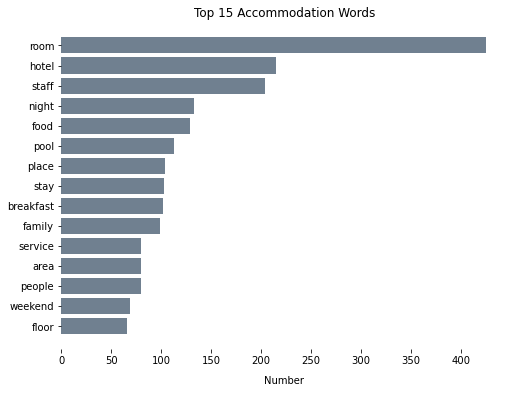

In [527]:
graphmatplot(accom_count,"Top 15 Accommodation Words")

In [529]:
# Top 10 nouns associated with food and the frequencies
food_count.head(10)

,Word,Count
0,food,1012
1,staff,483
2,service,458
3,meal,316
4,restaurant,296
5,place,274
6,order,227
7,chip,216
8,menu,193
9,lunch,189


In [530]:
food_count.to_csv("FOOD_NOUNS.csv")

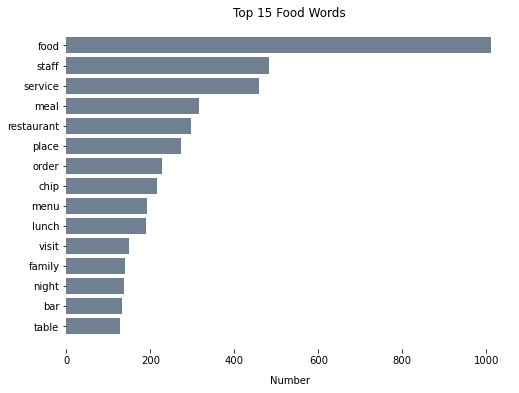

In [531]:
graphmatplot(food_count,"Top 15 Food Words")

In [533]:
# Top 10 nouns associated with attractions and the frequencies
attract_count.head(10)

,Word,Count
0,beach,22
1,food,20
2,visit,20
3,money,16
4,room,16
5,area,16
6,staff,15
7,park,14
8,car,13
9,garden,12


In [534]:
attract_count.to_csv("ATTRACT_NOUNS.csv")

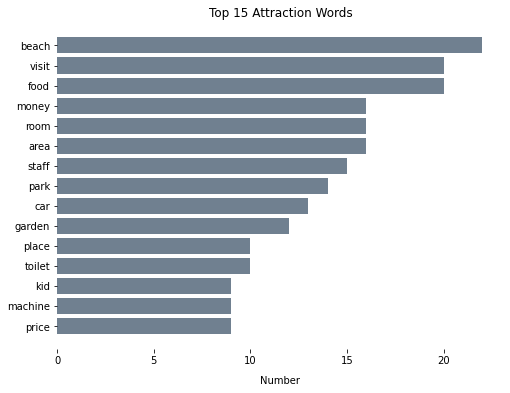

In [535]:
graphmatplot(attract_count,"Top 15 Attraction Words")

* Using just nouns gives a good idea of the important themes based on frequency of noun occurrence 
* Certain words like 'car-park' are not picked up as it splits them into car and park so bigrams might be better

# Section 5: Bigrams

In [537]:
nouns_accom["bigrams"] = nouns_accom["nouns"].apply(lambda x: ngrams(x,2))
nouns_food["bigrams"] = nouns_food["nouns"].apply(lambda x: ngrams(x,2))
nouns_attract["bigrams"] = nouns_attract["nouns"].apply(lambda x: ngrams(x,2))

In [538]:
nouns_accom["bigrams_count"] = nouns_accom["bigrams"].apply(Counter)
nouns_food["bigrams_count"] = nouns_food["bigrams"].apply(Counter)
nouns_attract["bigrams_count"] = nouns_attract["bigrams"].apply(Counter)

In [689]:
# Example review
print(nouns_accom["bigrams_count"].iloc[0])

Counter({('room', 'view'): 1, ('view', 'room'): 1, ('room', 'floor'): 1, ('floor', 'occupancy'): 1, ('occupancy', 'part'): 1, ('part', 'pool'): 1, ('pool', 'accomodation'): 1, ('accomodation', 'parking'): 1, ('parking', 'problem'): 1, ('problem', 'alison'): 1, ('alison', 'permit'): 1, ('permit', 'sort'): 1, ('sort', 'breakfast'): 1, ('breakfast', 'hash'): 1, ('hash', 'breakfast'): 1, ('breakfast', 'pudding'): 1, ('pudding', 'room'): 1, ('room', 'shade'): 1, ('shade', 'decor'): 1, ('decor', 'bit'): 1, ('bit', 'armchair'): 1, ('armchair', 'thing'): 1, ('thing', 'street'): 1})


In [690]:
# Save files for Topic Model Notebook
nouns_accom.to_csv("NOUNS_ACCOM.CSV")
nouns_food.to_csv("NOUNS_FOOD.csv")
nouns_attract.to_csv("NOUNS_ATTRACT.CSV")

In [540]:
accom_bigram = pd.DataFrame(nouns_accom["bigrams_count"].sum().most_common(),columns = ["Word","Count"] )
accom_bigram["Word"] = accom_bigram["Word"].apply(lambda x: ' '.join(x))

In [541]:
accom_bigram.head(15)

,Word,Count
0,room room,27
1,staff room,20
2,hotel room,18
3,car park,14
4,value money,13
5,night stay,12
6,pool pool,12
7,customer service,12
8,place stay,10
9,member staff,10


In [543]:
food_bigram = pd.DataFrame(nouns_food["bigrams_count"].sum().most_common(),columns = ["Word","Count"] )
food_bigram["Word"] = food_bigram["Word"].apply(lambda x: ' '.join(x))

In [544]:
food_bigram.head(15)

,Word,Count
0,food service,84
1,staff food,53
2,service food,51
3,food staff,43
4,value money,35
5,customer service,34
6,restaurant food,28
7,food food,27
8,food order,23
9,quality food,22


In [546]:
attract_bigram = pd.DataFrame(nouns_attract["bigrams_count"].sum().most_common(),columns = ["Word","Count"] )
attract_bigram["Word"] = attract_bigram["Word"].apply(lambda x: ' '.join(x))

In [547]:
attract_bigram.head(15)

,Word,Count
0,car park,11
1,food drink,4
2,value money,3
3,money car,3
4,park entrance,3
5,lamb daughter,2
6,gift shop,2
7,fun fun,2
8,walk dog,2
9,visit hour,2


# Section 6: Nouns and Adjective Pairs

In [695]:
# Bring in files from Keywords Notebook
df_accom = pd.read_csv("NOUNS_ACCOM.csv",index_col = 0)
df_food = pd.read_csv("NOUNS_FOOD.csv",index_col = 0)
df_attract = pd.read_csv("NOUNS_ATTRACT.csv",index_col = 0)

In [696]:
# Function to drop nulls, drop unwanted columns,transform column which is a string to literal, then to a list

def prep(df):
    df.dropna(inplace = True)
    df_new = df.drop(columns = ["Sent","Pos","noun_phrases","nouns_count","bigrams","bigrams_count"],axis = 1)
    df_new["nouns"] = df_new["nouns"].apply(lambda x: ast.literal_eval(x))
    words = df_new.nouns.values.tolist()
    return df_new, words

In [699]:
# Run function
accom_df, accom_nouns = prep(df_accom)
food_df,food_nouns = prep(df_food)
attract_df,attract_nouns = prep(df_attract)

In [700]:
# Get the nouns and adjective pairs
#nlp = nlp = spacy.load("en.core.web.sm")

import en_core_web_sm
nlp = en_core_web_sm.load()

def transform(x):
    doc = nlp(x)
    noun_adj_pairs = {}
    for chunk in doc.noun_chunks:
        adj = []
        noun = ""
        for tok in chunk:
            if tok.pos_ == "NOUN":
                noun = tok.text
            if tok.pos_ == "ADJ":
                adj.append(tok.text)
        adj = ' '.join(adj)
        if noun:
            noun_adj_pairs.update({noun:adj}) 
    return noun_adj_pairs

In [701]:
# Run the function
df_accom["noun_adj"] = df_accom["Sent_clean"].apply(lambda x: transform(x))
df_food["noun_adj"] = df_food["Sent_clean"].apply(lambda x: transform(x))
df_attract["noun_adj"] = df_attract["Sent_clean"].apply(lambda x: transform(x))

In [702]:
# Split the items out and  put onto separate lines in the dataframe
df_accom["noun_adj"] = df_accom["noun_adj"].apply(lambda x: [(k, v) for k, v in x.items()])
df_food["noun_adj"] = df_food["noun_adj"].apply(lambda x: [(k, v) for k, v in x.items()])
df_attract["noun_adj"] = df_attract["noun_adj"].apply(lambda x: [(k, v) for k, v in x.items()])

df_accom = df_accom.explode("noun_adj")
df_food = df_food.explode("noun_adj")
df_attract = df_attract.explode("noun_adj")

In [710]:
# Look at example review
df_accom["noun_adj"][0]

0              (view, central excellent)
0                           (floor, top)
0                          (occupancy, )
0                            (workman, )
0                               (part, )
0                         (parking, new)
0                             (permit, )
0                          (brown, good)
0    (room, english edible squeak black)
0                      (armchair, green)
0                         (street, high)
Name: noun_adj, dtype: object

# Section 7: Summary

Comments:

* Keyword extraction identified key words in the reviews which helps to identify some of the main aspects in the reviews
* Bigrams give more perspective by linking words like 'car' and 'park' together
* There is quite a lot of repetition amongst the bigrams for the food category in particular, with the word 'food' being teamed up with many other different words, in particular the word 'service'. This suggests the topics might be fuzzy.
* Unigrams and Bigrams are a bit too specific, more useful would be topics based on the distribution of topics such as that provided by topic modelling which is considered in the Notebook - Topic Models
